# Leg Point Definition
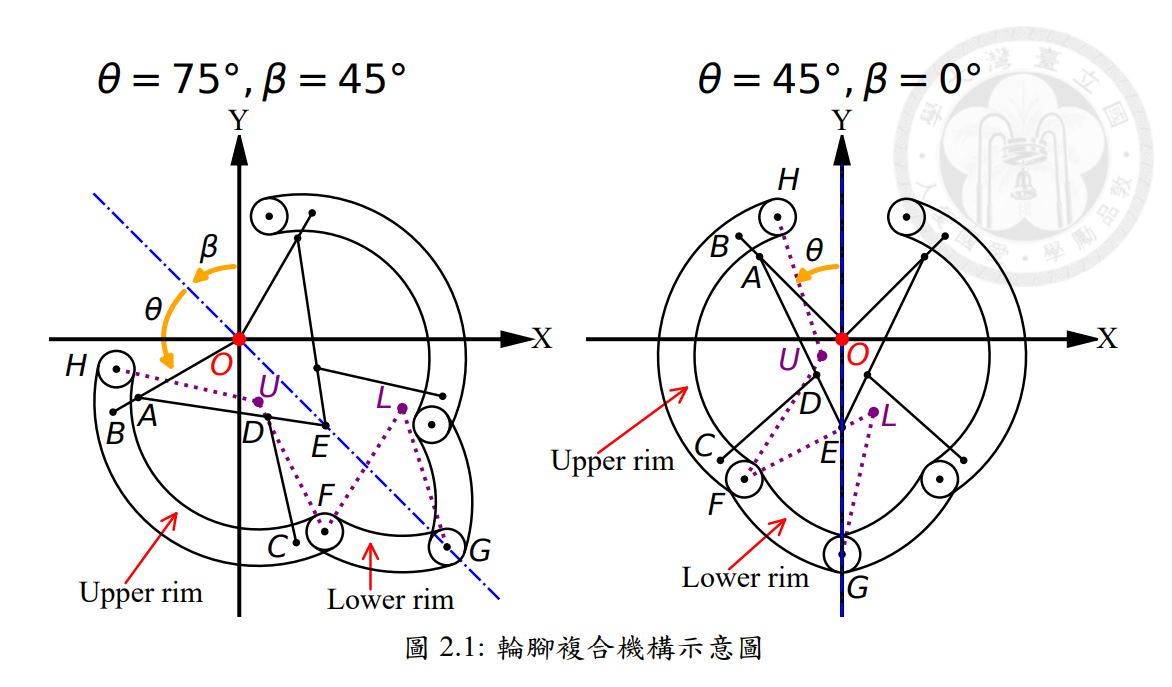
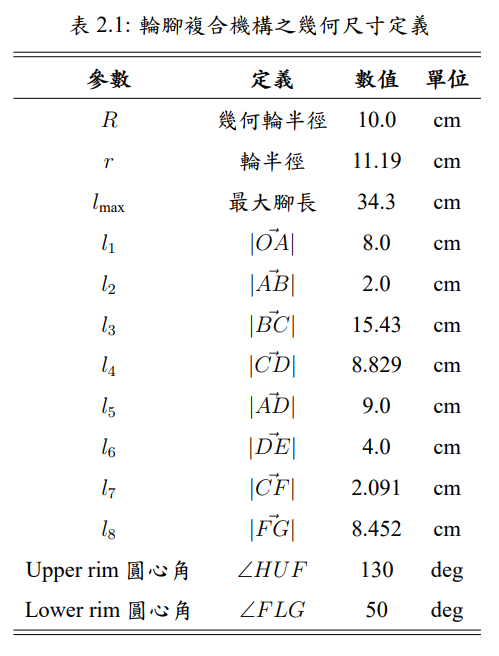

## env setup

In [1]:
import numpy as np
import sys
try:
    import LegModel
    import PlotLeg
    import FittedCoefficient
except ModuleNotFoundError:
    sys.path.append('../')
    import LegModel
    import PlotLeg
    import FittedCoefficient
theta = 17
beta = 0


In [2]:
Leg = LegModel.LegModel()


In [3]:
def complex_to_vec(pos):
    return np.array(pos.real, pos.imag)

In [4]:
def plot_point(ax, point, color='red',plot_leg=PlotLeg.PlotLeg()):
    point = ax.plot(point[0], point[1], marker='o', color=color, markersize=plot_leg.leg_shape.mark_size, zorder=plot_leg.leg_shape.zorder+0.00001)[0]


# Plotting Leg

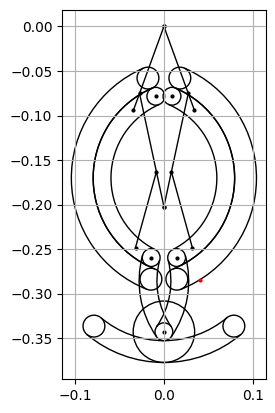

In [5]:
import matplotlib.pyplot as plt
plot_leg = PlotLeg.PlotLeg()  # rad
ax = plot_leg.plot_by_angle(np.deg2rad(160), np.deg2rad(0))
# plot_leg.setting(mark_size=10, line_width=3, color='red')
# ax.plot(complex_to_vec(plot_leg.rim_point(40)), marker='o', color='red', markersize=plot_leg.leg_shape.mark_size, zorder=plot_leg.leg_shape.zorder+0.00001) # plot the ground point
# ax.plot(plot_leg.rim_point(0)[0],plot_leg.rim_point(0)[1], marker='o', color='red', markersize=plot_leg.leg_shape.mark_size, zorder=plot_leg.leg_shape.zorder+0.00001) # plot the ground point
plot_point(ax, plot_leg.rim_point(50), color='red', plot_leg=plot_leg)
ax.grid()
plt.show()

# Rim points

## setup

In [6]:
import matplotlib.pyplot as plt

T = np.array([np.deg2rad(i) for i in range(17,160)])
B = np.array([i*0 for i in range(17,160)])
leg = LegModel.LegModel()
leg.forward(T,B)
# rim_dict[alpha] returns a list of rim points for the given alpha in cartesian coordinates
rim_dict = {}
# rim_dict_polar[alpha] returns a list of rim points for the given alpha in polar coordinates
rim_dict_polar = {}

for alpha in range(-180,180,1):
    rim_dict[alpha] = leg.rim_point(alpha)
    rim_dict_polar[alpha] = []
    # Convert cartesian coordinates to polar coordinates
    for point in rim_dict[alpha]:
        r = np.sqrt(point[0]**2 + point[1]**2)
        theta = np.arctan2(point[1], point[0])
        rim_dict_polar[alpha].append((r, theta))
# print(rim_dict[0])



## Plot

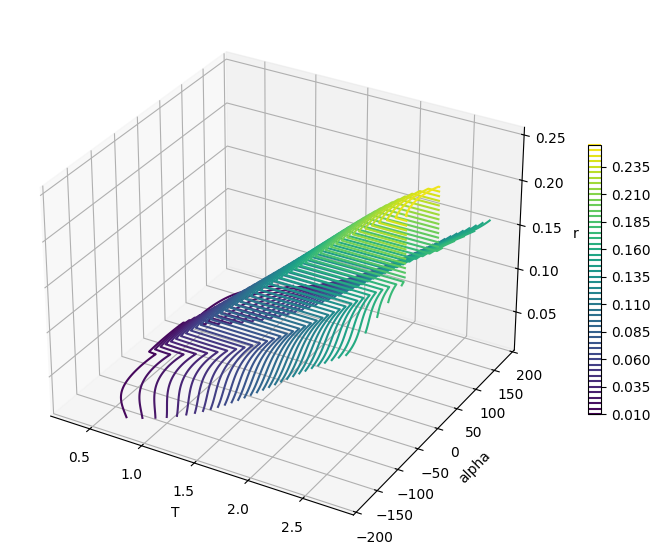

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for 3D contour
T_grid, alpha_grid = np.meshgrid(T, list(rim_dict.keys()))
r_grid = np.zeros_like(T_grid, dtype=float)

for i, a in enumerate(list(rim_dict.keys())):
    for j, t in enumerate(T):
        # Use the first rim point for each alpha and T
        vec = rim_dict_polar[a][j]
        r_grid[i, j] = vec[0]

fig = plt.figure(figsize=(10, 7))
ax3d = fig.add_subplot(111, projection='3d')
contour = ax3d.contour3D(T_grid, alpha_grid, r_grid, 50, cmap='viridis')
ax3d.set_xlabel('T')
ax3d.set_ylabel('alpha')
ax3d.set_zlabel('r')
fig.colorbar(contour, ax=ax3d, shrink=0.5)
plt.show()

### r vs theta

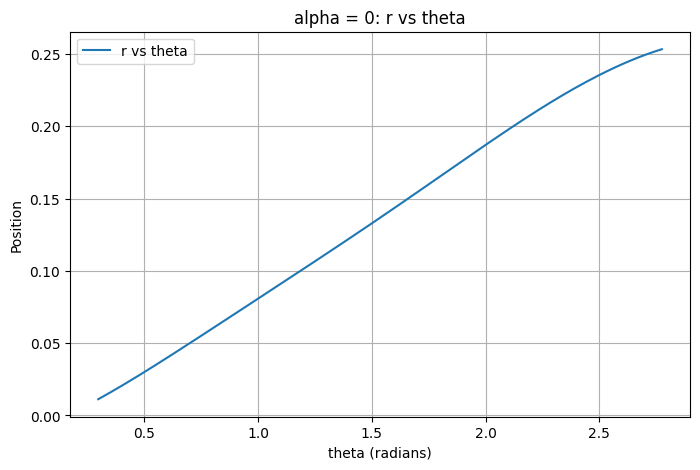

In [8]:
import matplotlib.pyplot as plt

alpha_zero_points = rim_dict_polar[0]
theta_vals = T

r = [pt[0] for pt in alpha_zero_points]
# y = [pt[1] for pt in alpha_zero_points]

plt.figure(figsize=(8, 5))
plt.plot(theta_vals, r, label='r vs theta')
plt.xlabel('theta (radians)')
plt.ylabel('Position')
plt.title('alpha = 0: r vs theta')
plt.legend()
plt.grid()
plt.show()

### r vs alpha ( foot rim )

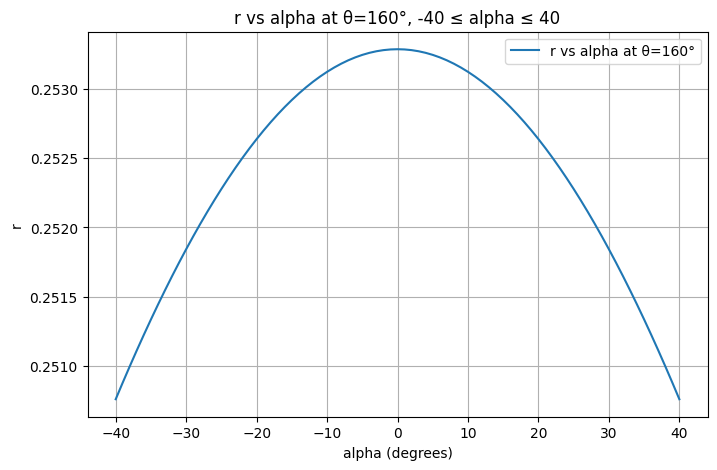

In [9]:
import matplotlib.pyplot as plt

# Find the index in theta_vals closest to 160 degrees in radians
theta_160_rad = np.deg2rad(160)
idx = (np.abs(theta_vals - theta_160_rad)).argmin()

# Extract r values for theta = 160deg across all alpha
r_160 = r_grid[:, idx]
alpha_list = list(rim_dict.keys())

# Filter alpha and r_160 for -40 <= alpha <= 40
alpha_filtered = [a for a in alpha_list if -40 <= a <= 40]
r_160_filtered = [r_160[i] for i, a in enumerate(alpha_list) if -40 <= a <= 40]

plt.figure(figsize=(8, 5))
plt.plot(alpha_filtered, r_160_filtered, label='r vs alpha at θ=160°')
plt.xlabel('alpha (degrees)')
plt.ylabel('r')
plt.title('r vs alpha at θ=160°, -40 ≤ alpha ≤ 40')
plt.legend()
plt.grid()
plt.show()


# Trajectory

## assumptions 
1. pure rolling at contact
2. contact point is normal to ground

    $ \overline{OO_r} =\hat{G}' - \hat{G}_0 $

    $L = 2\overline{OO_r}\sin(\beta)$

    $h = r_{rim} + \overline{OO_r}\cos(\beta)$

    $D = \displaystyle{\frac{L + R'2\beta}{3}}$

    $\displaystyle{=\frac{2\overline{OO_r}\sin(\beta)+R'2\beta}{3}}$

    $ W = L+D $

the height $h$ and distance $D$ would be desided by initial $\theta$ and $\beta$




## Duty Planning

$t_{d,sw}:t_{d,st} = 1:3$

Stand Time vs Swing Time would be 1:3 due to walking gait planning

$\displaystyle{\vec{V} = \frac{D}{t_{d,sw}}}$

## Traj API

### Class usage

In [10]:
# import 
import Trajectory_Planning as TJ
# declare
Traj = TJ.TrajectoryPlanner(stand_height=0.3,
                            step_length=0.4,
                            leg=LegModel.LegModel(),
                            step_height=0.04,
                            period=10,
                            dt=0.001,
                            duty=1 / 4,
                            overlap=0.2)
# set_speed : set target speed in m/s
Traj.set_speed(0.04)

# generate trajectory curve
Traj.move()

# get Curve Data in [x,y] points
sp = Traj.generate_swing_trajectory()

#get theta beta cmd
# type: 2d list [[theta0,beta0] ...[theta_n, beta_n] ]
curve_cmd = Traj["cmd"]


### validation

In [11]:
print(type(curve_cmd ))

<class 'list'>


### Plot: h vs D only changing $\theta$

In [12]:
THETA = np.array([np.deg2rad(i) for i in range(17,161)])
BETA = np.array([0 for i in range(17,161)])
leg.forward(THETA,BETA, vector=False)
OO_r = np.array([-leg["O_r"].imag]).T
beta_ = np.deg2rad(40)
r_rim = (leg["R"] + leg["foot_offset"] + leg["tyre_thickness"])
L = OO_r*2*np.sin(beta_)
H = r_rim + OO_r*np.cos(beta_)
D = (L+r_rim*2*beta_)/3


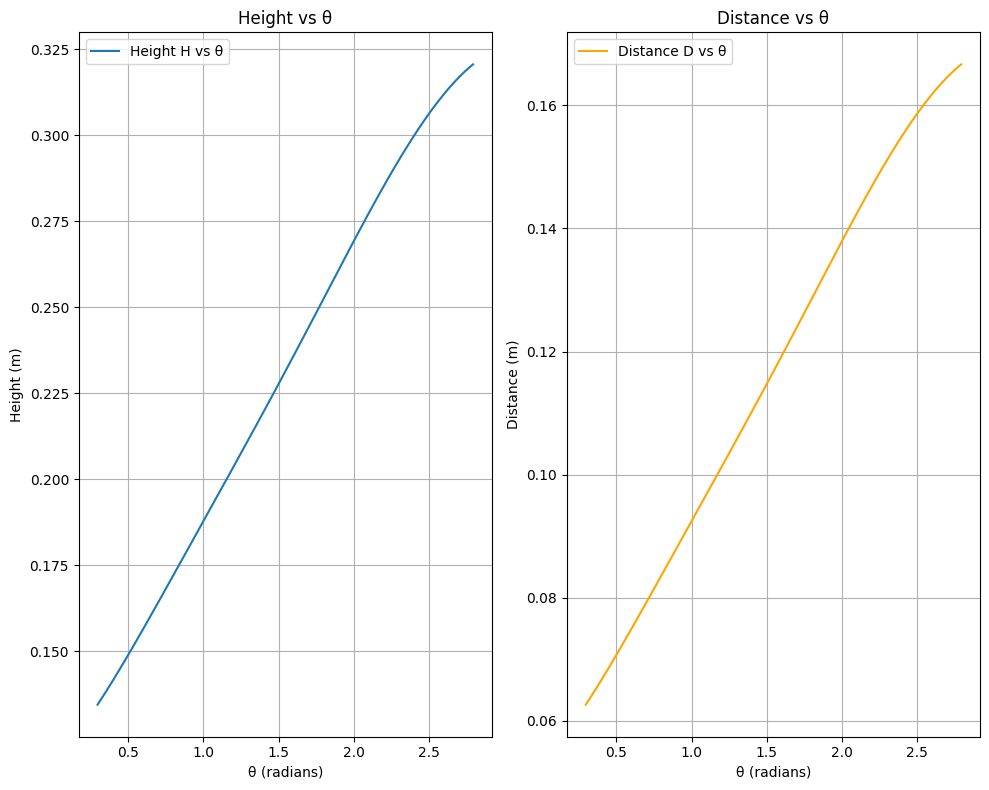

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# Plot Height vs theta
ax1.plot(THETA, H, label='Height H vs θ')
ax1.set_xlabel('θ (radians)')
ax1.set_ylabel('Height (m)')
ax1.set_title('Height vs θ')
ax1.legend()
ax1.grid()

# Plot Distance vs theta
ax2.plot(THETA, D, label='Distance D vs θ', color='orange')
ax2.set_xlabel('θ (radians)')
ax2.set_ylabel('Distance (m)')
ax2.set_title('Distance vs θ')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()


## flow for trajectary planning
1. Select Stand Height and Step Length
2. get start point ($\theta, \beta$)
3. derive bezier curve
4. combine two curves

### init setup

In [14]:
from Solver import Solver
import numpy as np
from FittedCoefficient import inv_G_dist_poly
import Trajectory_Planning as TJ
stand_height = 0.35
step_length = 0.3
leg = LegModel.LegModel()
traj = TJ.TrajectoryPlanner(stand_height=0.3,
                            step_length=0.4,
                            leg=LegModel.LegModel(),
                            step_height=0.04,
                            period=10,
                            dt=0.001,
                            duty=1 / 4,
                            overlap=0.2)
theta0, beta0, D = traj.get_init_tb()

### Plot: rolling start point

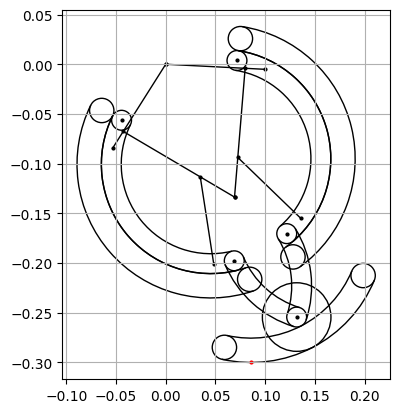

In [15]:
np.rad2deg([theta0, beta0])
plot_leg = PlotLeg.PlotLeg(leg)  # rad
ax = plot_leg.plot_by_angle(theta0, beta0)
plot_point(ax, plot_leg.rim_point(np.rad2deg(-beta0)), color='red', plot_leg=plot_leg)
ax.grid()
plt.show()

### func: init $\theta$, $\beta$ using stand height and step length

In [16]:
# ====================< function to joint angles >===================
# function to transfer stand height and step length to joint angles
# ===================================================================
def get_init_tb(stand_height, step_length, leg = LegModel.LegModel()):

    H = stand_height-leg["foot_radius"]
    func = lambda x: (H)*np.tan(x) + leg["foot_radius"]*x - 3*step_length/8
    # solver to solve beta
    solver = Solver(
        method="Secant",
        tol=1e-6,
        max_iter=100,
        function= func,
        derivative= lambda x: (H)*np.sec(x)**2 + leg["foot_radius"] - 3*step_length/8
    )
    beta0 = solver.solve(0, np.deg2rad(40))

    # calculate foot position
    G_dist = (H)/np.cos(beta0) + leg["R"]
    OO_r_Dist = G_dist - leg["R"]
    theta0 = inv_G_dist_poly(G_dist)

    L = 2*OO_r_Dist*np.sin(beta0)       # distance of ground contact to hip joint in X axis
    D = (L+leg.foot_radius*2*beta0)/3   # movement of hip joint in X axis during one step
    return theta0, beta0, D


### Plot: Swing Phase Curve

#### Plot 1: generated curve by trajectory

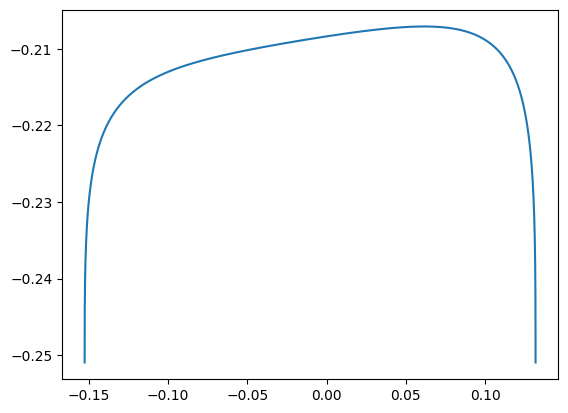

In [17]:
from bezier import swing
import time
import Trajectory_Planning as TJ
traj_planner = TJ.TrajectoryPlanner(stand_height=0.3,
                                    step_length=0.4,
                                    leg=LegModel.LegModel(),
                                    step_height=0.04,
                                    period=10,
                                    dt=0.001,
                                    duty=1 / 4,
                                    overlap=0.2)
traj_planner.set_speed(0.1)
traj_planner.move()

leg = LegModel.LegModel()
theta0, beta0, D = traj_planner.get_init_tb()

start = time.time()
sp = traj_planner.generate_swing_trajectory()
end = time.time()
d = np.linspace(0, 1, 10000)
curve_points = [sp.getFootendPoint(_) for _ in d]
x_ = [p[0] for p in curve_points]
y_ = [p[1] for p in curve_points]
plt.plot(x_, y_)
plt.show()

#### Plot 2: validation in ploar coord.

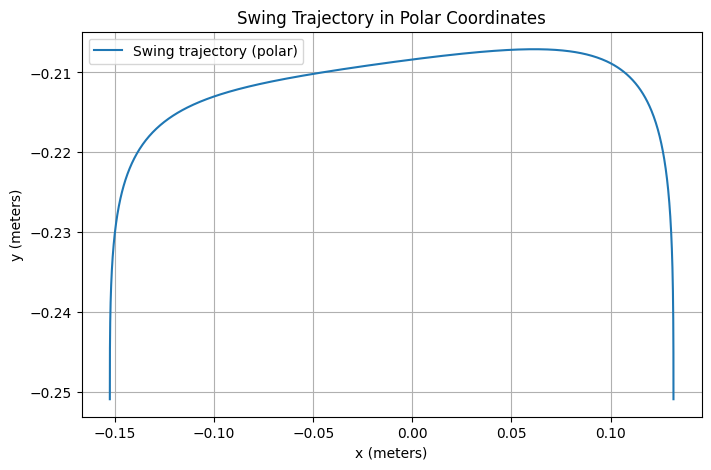

In [18]:
polar = traj_planner["swing_points_polar"]
import matplotlib.pyplot as plt

# Extract r and theta from polar coordinates
x = [p[0]*np.cos(p[1]) for p in polar]
y = [p[0]*np.sin(p[1]) for p in polar]

plt.figure(figsize=(8, 5))
plt.plot(x, y, label='Swing trajectory (polar)')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Swing Trajectory in Polar Coordinates')
plt.legend()
plt.grid()
plt.show()

#### Plot 3: validation using $\theta,\beta$ command

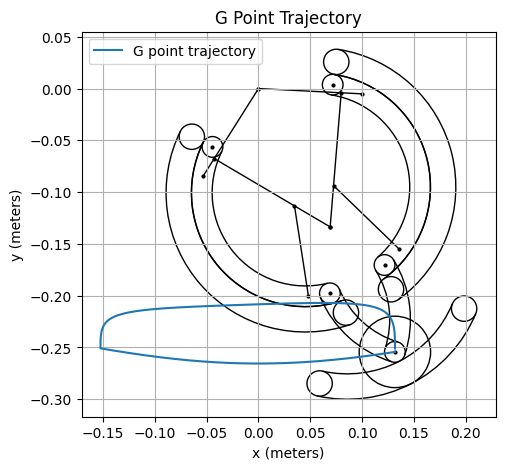

In [19]:
plot_leg = PlotLeg.PlotLeg(leg)  # rad
CMD = np.array(traj_planner["cmd"])
THETA = CMD.transpose(1,0)[0]
BETA = CMD.transpose(1,0)[1]
leg.forward(THETA,BETA, vector=False)
point_g = leg["G"].copy()

fig,ax = plt.subplots(figsize=(8, 5))
ax.plot(point_g.real, point_g.imag, label='G point trajectory')
ax.set_xlabel('x (meters)')
ax.set_ylabel('y (meters)')
ax.set_title('G Point Trajectory')
plot_leg.plot_by_angle(traj_planner.theta0, traj_planner.beta0, ax=ax)
ax.legend()
ax.grid()
plt.show()

#### testing

In [20]:
def transform(joint):
    # build cmd to transfer from [17 deg, 0] to [joint] in 5000 steps
    theta, beta = joint[0], joint[1]
    T = np.linspace(np.deg2rad(17), theta, 5000).tolist()
    B = np.linspace(0, beta, 5000).tolist()
    # stack into two columns: [[theta0, beta0], ...]
    # cmd = [[T[i], B[i]] for i in range(5000)]
    cmd = [[T], [B]]
    return cmd

In [21]:
T[0]

np.float64(0.29670597283903605)

## 2D contour for (D,H) $\theta , \beta $

In [22]:
THETA = np.array([np.deg2rad(i) for i in range(17,161)])
BETA = np.array([0 for i in range(17,161)])
leg.forward(THETA,BETA, vector=False)
OO_r = np.array([-leg["O_r"].imag]).T
beta_ = [np.deg2rad(i) for i in [0,10,20,30,40]]
D_dict = {}
W_dict = {}
H_dict = {}

for b in beta_:
    r_rim = (leg["R"] + leg["foot_offset"] + leg["tyre_thickness"])
    L = OO_r*2*np.sin(b)
    H = r_rim + OO_r*np.cos(b)
    D = (L+r_rim*2*b)/3
    
    W_dict[b] = L+D
    D_dict[b] = D
    H_dict[b] = H

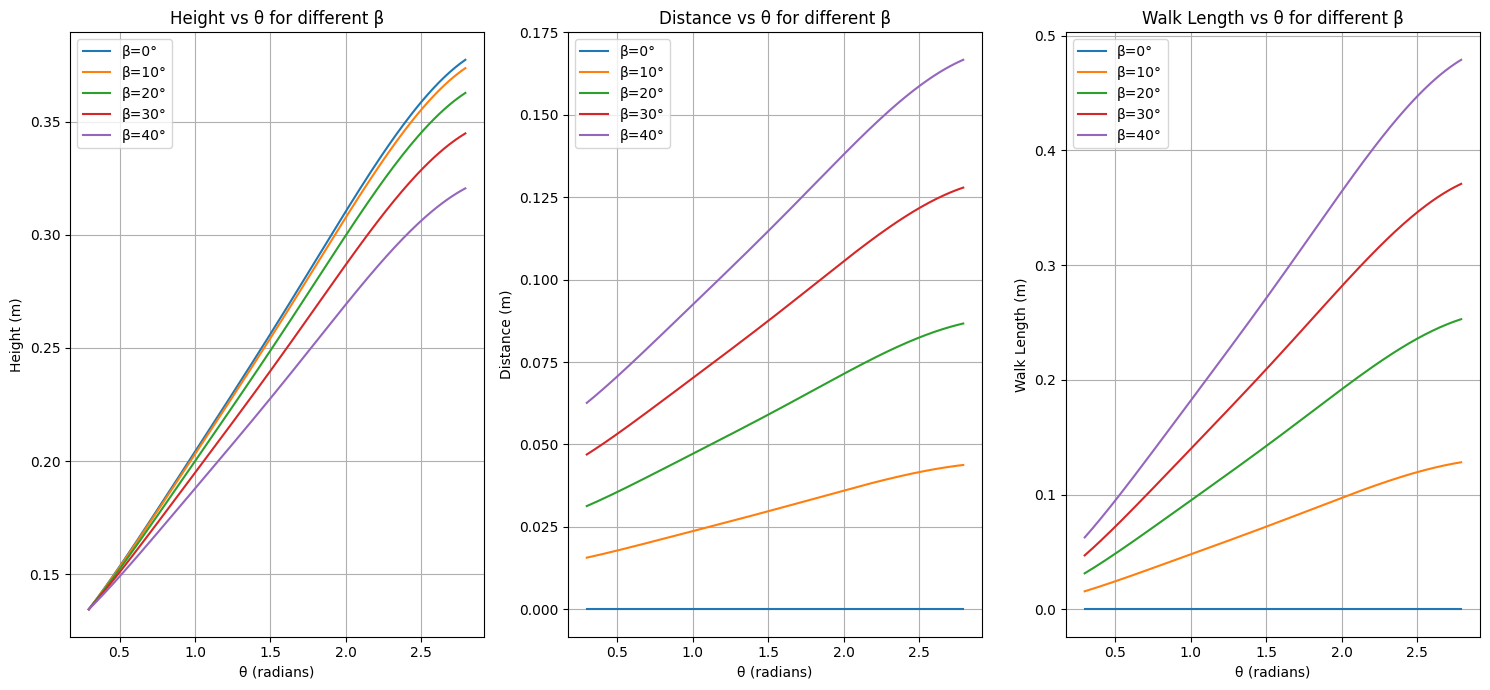

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

l_ = [0,10,20,30,40]
for b in beta_:
    # Plot Height vs theta for different beta values
    ax1.plot(THETA, H_dict[b], label=f'β={l_[beta_.index(b)]}°')
    # Plot Distance vs theta for different beta values
    ax2.plot(THETA, D_dict[b], label=f'β={l_[beta_.index(b)]}°')
    # Plot Walk length vs theta for different beta values
    ax3.plot(THETA, W_dict[b], label=f'β={l_[beta_.index(b)]}°')

ax1.set_xlabel('θ (radians)')
ax1.set_ylabel('Height (m)')
ax1.set_title('Height vs θ for different β')
ax1.legend()
ax1.grid()

ax2.set_xlabel('θ (radians)')
ax2.set_ylabel('Distance (m)')
ax2.set_title('Distance vs θ for different β')
ax2.legend()
ax2.grid()

ax3.set_xlabel('θ (radians)')
ax3.set_ylabel('Walk Length (m)')
ax3.set_title('Walk Length vs θ for different β')
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()


In [24]:
max(W_dict)

np.float64(0.6981317007977318)

# Optimize Solver for equations

In [25]:
from Solver import Solver

In [26]:
# Example usage
# solve: x^2 = 2
solver = Solver(
    method="Newton",
    tol=1e-6,
    max_iter=100,
    function=lambda x: x**2 - 2,
    derivative=lambda x: 2*x
)
root = solver.solve(1.0)
print("Root found:", root)

Root found: 1.4142135623730951


In [27]:
import numpy as np
# example sin(a) = sqrt(2)/2
solver = Solver(
    method="Regula Falsi",
    tol=1e-6,
    max_iter=100,
    function=lambda x: np.sin(x) - np.sqrt(2)/2,
    derivative=lambda x: np.cos(x)
)
root = solver.solve(np.pi/3, np.pi/8)
print("Root found:", np.rad2deg(root))

Root found: 45.00000000000001


# Design of Experinment(DOE)

## Params.
1. Velocity
2. Stand Height
3. Step Length
4. step height

## DOE
Since there are too many combinations, we must pick serval datas to analyze
Using 

### generate experinment table

In [28]:
# 產生新實驗設計：使用使用者提供的水準
# 假設說明（我會在回覆中說明）：
# - V 代表速度，使用者給的 [5,10,20,30] 我假設單位是 cm/s -> 轉換為 m/s（除以100）供實驗表使用
# - H 代表機身高度 body_h (cm)：[20,25,30]
# - L 代表步長 step_len (cm)：[15,20,30,40]
# - foot_lift 保持固定為 4 cm（如需改再告訴我）
#
# 產生全因子設計：3 * 4 * 4 = 48 組條件
# 輸出：design_48_runs.csv 與 experiment_record_template_48.csv，並顯示前 20 列

import itertools, random, pandas as pd

# 使用者提供的水準
V_cm_per_s = [5, 10, 20, 30]  # user-specified; assume cm/s -> convert to m/s
V_m_per_s = [v/100.0 for v in V_cm_per_s]  # m/s
H_cm = [20, 25, 30]  # body height in cm
L_cm = [15, 20, 30, 40]  # step length in cm
foot_lift_fixed = 8  # cm, kept from previous setting

# 產生組合
combinations = list(itertools.product(H_cm, L_cm, V_m_per_s))
design = []
for idx, (h, l, v) in enumerate(combinations, start=1):
    design.append({
        'run_index': idx,
        'body_h_cm': h,
        'step_len_cm': l,
        'speed_m_per_s': v,
        'speed_cm_per_s': int(v*100),  # keep original user units for clarity
        'foot_lift_cm': foot_lift_fixed
    })

design_df = pd.DataFrame(design)

# 隨機化順序（固定 seed 42 以便重現）
random.seed(42)
shuffled = design_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled['rand_order'] = range(1, len(shuffled)+1)

# 儲存 CSV
design_path = 'design_48_runs.csv'
# shuffled.to_csv(design_path, index=False)

# 建立實驗紀錄範本（含必要欄位）
template_cols = [
    'rand_order', 'run_index', 'date', 'operator', 'body_h_cm', 'step_len_cm', 'speed_cm_per_s', 'speed_m_per_s',
    'foot_lift_cm', 'distance_m', 'time_s', 'avg_voltage_V', 'avg_current_A', 'energy_Wh', 'avg_power_W',
    'CoT', 'Wh_per_m', 'SOC_start_percent', 'SOC_end_percent', 'temp_C', 'notes'
]
template_df = shuffled.copy()
# 新增欄位（空白）
for col in template_cols:
    if col not in template_df.columns:
        template_df[col] = ""

# 重新排列欄位順序並儲存
template_df = template_df[template_cols]
template_path = 'experiment_record_template_48.csv'
# template_df.to_csv(template_path, index=False)

# 顯示前 20 列
# display_dataframe_to_user("Design (48 runs) - first 20 rows", shuffled.head(20))

{"design_csv": design_path, "template_csv": template_path, "n_runs": len(shuffled)}


{'design_csv': 'design_48_runs.csv',
 'template_csv': 'experiment_record_template_48.csv',
 'n_runs': 48}

### repeat 3 times

In [29]:
# 由於 kernel reset，需重新執行：重建資料框架並加 unique_id 與 replicate 欄位
import pandas as pd
import itertools, random

# 使用者提供的水準
V_cm_per_s = [5, 10, 20, 30]  # cm/s
V_m_per_s = [v/100.0 for v in V_cm_per_s]  # m/s
H_cm = [20, 25, 30]  # cm
L_cm = [15, 20, 30, 40]  # cm
foot_lift_fixed = 4  # cm

# 產生組合 (48 runs)
combinations = list(itertools.product(H_cm, L_cm, V_m_per_s))
design = []
for idx, (h, l, v) in enumerate(combinations, start=1):
    design.append({
        'run_index': idx,
        'body_h_cm': h,
        'step_len_cm': l,
        'speed_m_per_s': v,
        'speed_cm_per_s': int(v*100),
        'foot_lift_cm': foot_lift_fixed
    })

design_df = pd.DataFrame(design)

# 隨機化順序
shuffled = design_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled['rand_order'] = range(1, len(shuffled)+1)

# 建立實驗紀錄範本（含必要欄位）
template_cols = [
    'rand_order', 'run_index', 'date', 'operator', 'body_h_cm', 'step_len_cm',
    'speed_cm_per_s', 'speed_m_per_s', 'foot_lift_cm',
    'distance_m', 'time_s', 'avg_voltage_V', 'avg_current_A', 'energy_Wh',
    'avg_power_W', 'CoT', 'Wh_per_m', 'SOC_start_percent', 'SOC_end_percent',
    'temp_C', 'notes'
]
template_df = shuffled.copy()
for col in template_cols:
    if col not in template_df.columns:
        template_df[col] = ""

template_df = template_df[template_cols]

# --- 新增 replicate 與 unique_id ---
n_reps = 3
expanded_rows = []
for _, row in template_df.iterrows():
    for rep in range(1, n_reps+1):
        new_row = row.copy()
        new_row['replicate'] = rep
        new_row['unique_id'] = f"{int(row['run_index'])}_{rep}"
        expanded_rows.append(new_row)

expanded_df = pd.DataFrame(expanded_rows)

# 儲存新檔案
expanded_path = 'experiment_record_template_48_with_reps.csv'
# expanded_df.to_csv(expanded_path, index=False)

expanded_path


'experiment_record_template_48_with_reps.csv'

### generate exp csv

In [30]:
import pandas as pd
path = 'design_48_runs.csv'
df = pd.read_csv(path)
df

,run_index,body_h_cm,step_len_cm,speed_m_per_s,speed_cm_per_s,foot_lift_cm,rand_order
0,1,20,15,0.05,5,8,25
1,2,20,15,0.10,10,8,31
2,3,20,15,0.20,20,8,34
3,4,20,15,0.30,30,8,12
4,5,20,20,0.05,5,8,9
5,6,20,20,0.10,10,8,28
6,7,20,20,0.20,20,8,13
7,8,20,20,0.30,30,8,44
8,9,20,30,0.05,5,8,11
9,10,20,30,0.10,10,8,20


In [31]:
for i in df.index:
    print(df['run_index'][i])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [32]:
from Gait_Generator import Gait_Generator
gait = Gait_Generator()
gait.generate_gait()

In [37]:
df = pd.DataFrame(np.array(gait.CMDS).T)
df


,0,1,2,3,4,5,6,7
0,0.296706,0.000000,0.296706,0.000000,0.296706,0.000000,0.296706,0.000000
1,0.296962,-0.000095,0.296940,0.000043,0.296937,-0.000025,0.296975,0.000114
2,0.297217,-0.000189,0.297174,0.000086,0.297167,-0.000050,0.297244,0.000227
3,0.297473,-0.000284,0.297408,0.000129,0.297398,-0.000075,0.297513,0.000341
4,0.297729,-0.000379,0.297643,0.000172,0.297629,-0.000100,0.297783,0.000454
...,...,...,...,...,...,...,...,...
14995,1.469312,-0.223461,1.569597,0.464216,1.449118,0.117119,1.650714,-0.578029
14996,1.469620,-0.224675,1.568839,0.462955,1.448964,0.115916,1.651797,-0.579326
14997,1.469929,-0.225889,1.568083,0.461693,1.448811,0.114712,1.652885,-0.580624
14998,1.470241,-0.227104,1.567331,0.460433,1.448660,0.113508,1.653977,-0.581923
